In [1]:
import torch
from torchvision import models

In [2]:
#dir(models)

In [3]:
#Question 1
resnet = models.resnet101(pretrained=True)
#resnet

In [4]:
from torchvision import transforms
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )])

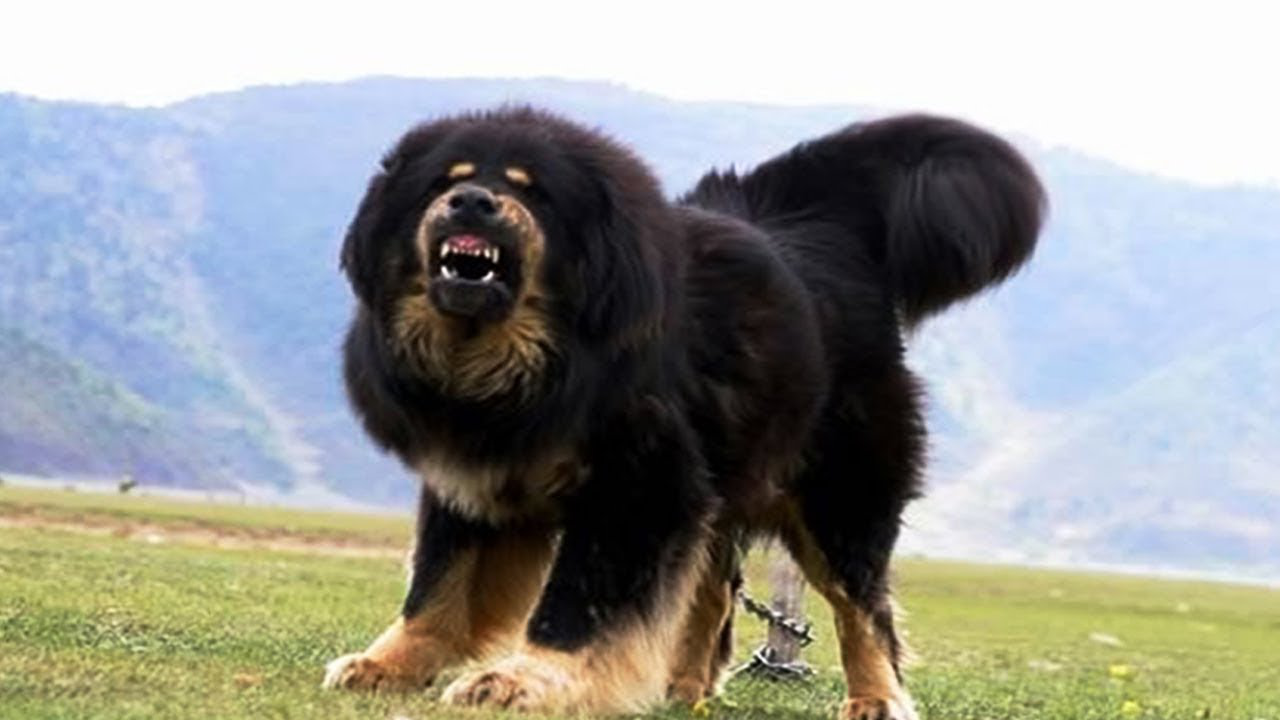

In [5]:
from PIL import Image
mastiff = Image.open(r"C:\Users\Barry Persing\Documents\ECGR4106\HW0\Mastiff.jpg")
mastiff

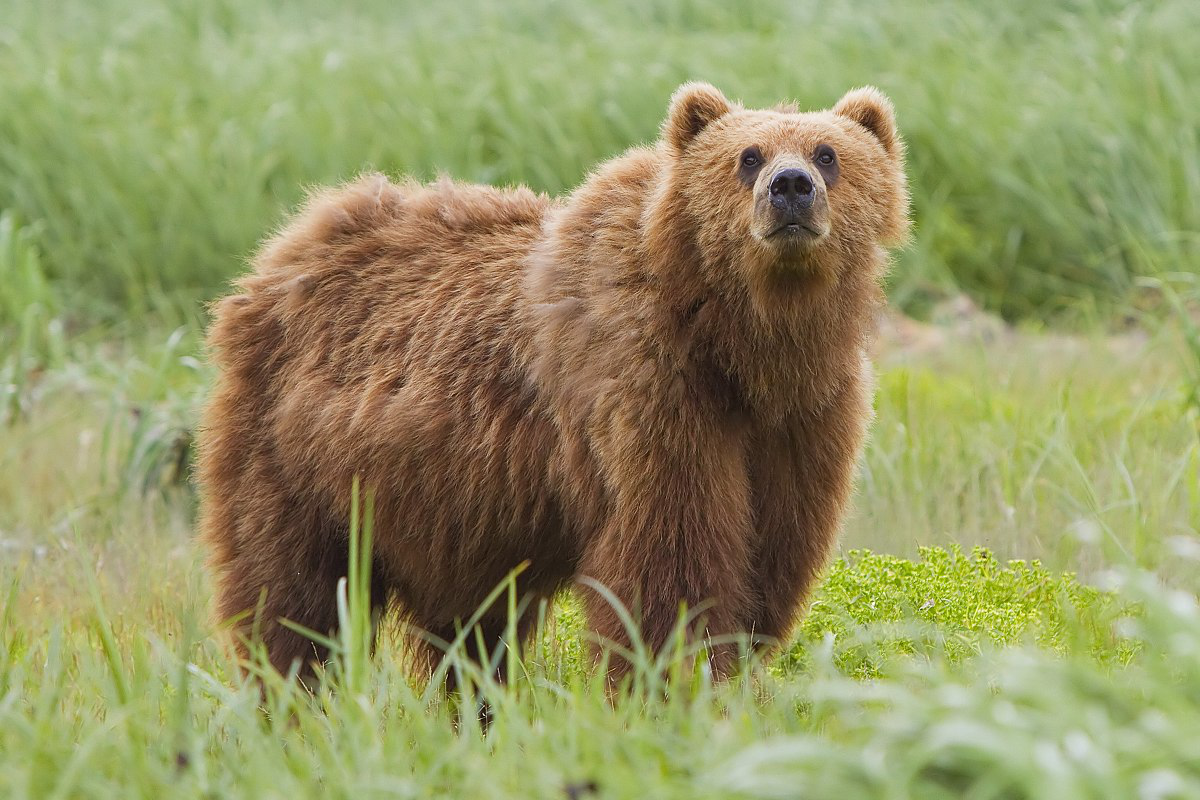

In [6]:
bear = Image.open(r"C:\Users\Barry Persing\Documents\ECGR4106\HW0\Bear.jpg")
bear

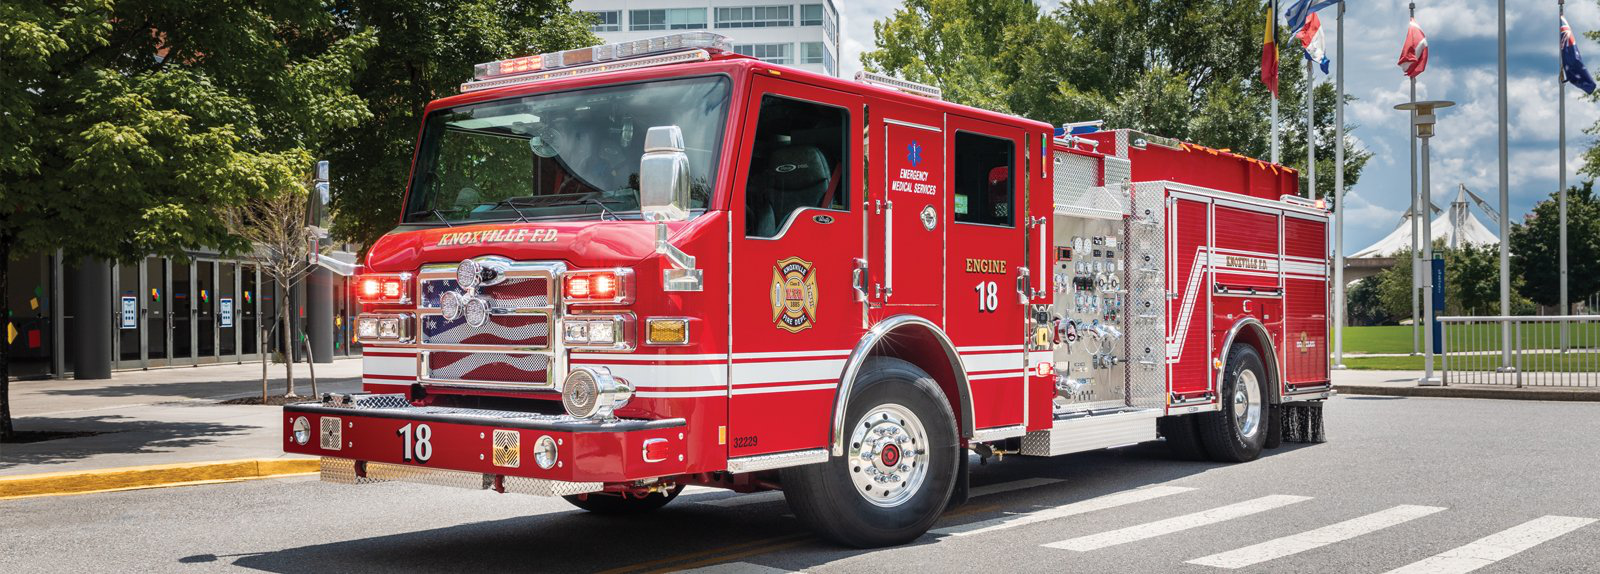

In [7]:
firetruck = Image.open(r"C:\Users\Barry Persing\Documents\ECGR4106\HW0\Firetruck.jpeg")
firetruck

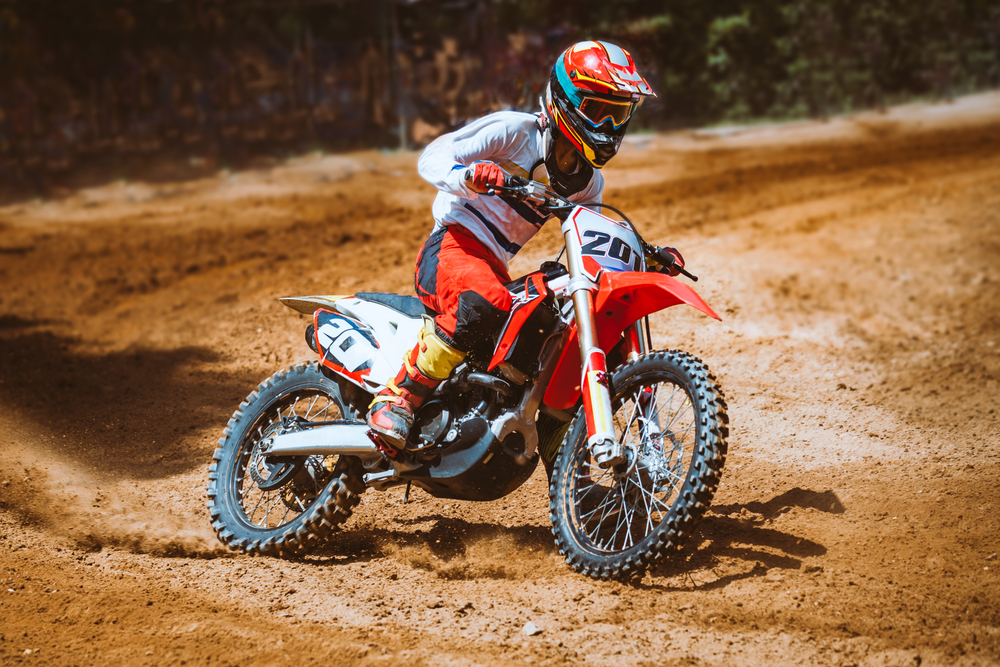

In [8]:
dirtbike = Image.open(r"C:\Users\Barry Persing\Documents\ECGR4106\HW0\Dirtbike.jpg")
dirtbike

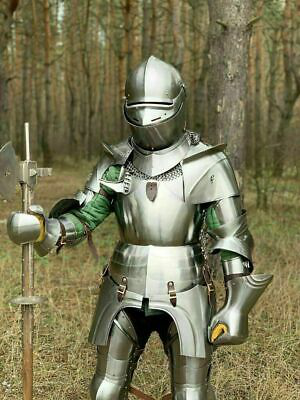

In [9]:
armor = Image.open(r"C:\Users\Barry Persing\Documents\ECGR4106\HW0\Armor.jpg")
armor

In [10]:
#Preprocess each image
img_t = preprocess(armor) #replace variable in arg to desired image
batch_t = torch.unsqueeze(img_t, 0)

In [11]:
#Evaluate
resnet.eval()
out = resnet(batch_t)
#out

In [12]:
#Get class labels
with open(r"C:\Users\Barry Persing\Documents\ECGR4106\HW0\imagenet_classes.txt") as f:
    labels = [line.strip() for line in f.readlines()]

In [13]:
#Generate classification results
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
_, indices = torch.sort(out, descending=True)
[(labels[idx], percentage[idx].item()) for idx in indices[0][:5]]

[('cuirass', 65.97520446777344),
 ('breastplate, aegis, egis', 32.751800537109375),
 ('shield, buckler', 0.9290367364883423),
 ('chain mail, ring mail, mail, chain armor, chain armour, ring armor, ring armour',
  0.3420317471027374),
 ('pickelhaube', 0.0013460651971399784)]

In [14]:
#QUESTION 2
import torch
import torch.nn as nn

#Required Classes from the reference reading:
class ResNetBlock(nn.Module): # <1>

    def __init__(self, dim):
        super(ResNetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)

    def build_conv_block(self, dim):
        conv_block = []

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim),
                       nn.ReLU(True)]

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x) # <2>
        return out


class ResNetGenerator(nn.Module):

    def __init__(self, input_nc=3, output_nc=3, ngf=64, n_blocks=9): # <3> 

        assert(n_blocks >= 0)
        super(ResNetGenerator, self).__init__()

        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=True),
                 nn.InstanceNorm2d(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                stride=2, padding=1, bias=True),
                      nn.InstanceNorm2d(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResNetBlock(ngf * mult)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=True),
                      nn.InstanceNorm2d(int(ngf * mult / 2)),
                      nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input): # <3>
        return self.model(input)


In [15]:
netG = ResNetGenerator() #generate model
#Load model data:
model_path = r"C:\Users\Barry Persing\Documents\ECGR4106\HW0\horse2zebra_0.4.0.pth"
model_data = torch.load(model_path)
netG.load_state_dict(model_data)

<All keys matched successfully>

In [16]:
netG.eval()

ResNetGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResNetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
     

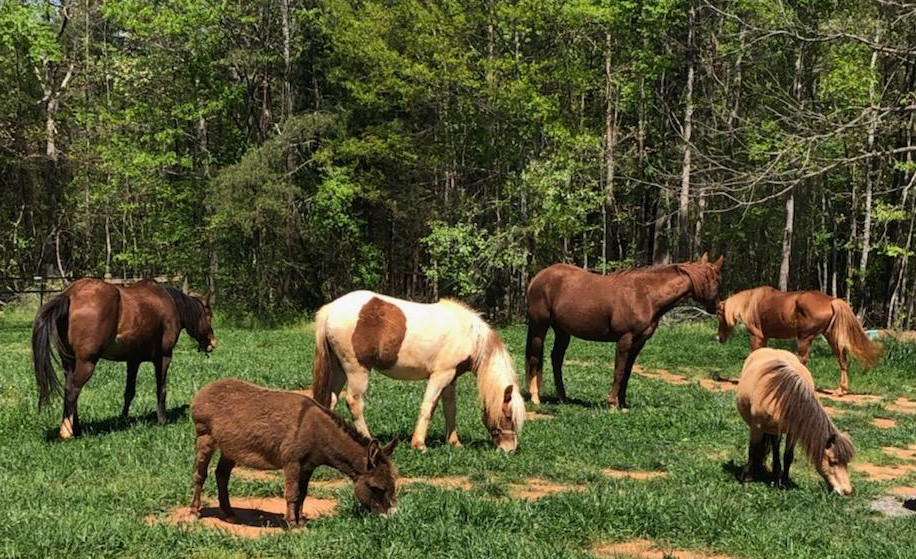

In [17]:
#Import image of a horse
from PIL import Image
from torchvision import transforms
preprocess = transforms.Compose([transforms.Resize(256),
    transforms.ToTensor()])
img = Image.open(r"C:\Users\Barry Persing\Documents\ECGR4106\HW0\horse9.jpg")
img

In [18]:
#Prepocess image
img_t = preprocess(img)
batch_z = torch.unsqueeze(img_t, 0)
batch_out = netG(batch_z)

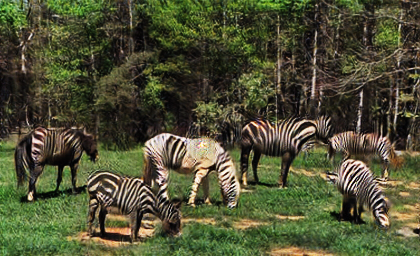

In [19]:
#Run image through model and obtain altered image
out_t = (batch_out.data.squeeze() + 1.0) / 2.0
out_img = transforms.ToPILImage()(out_t)
out_img.save(r"C:\Users\Barry Persing\Documents\ECGR4106\HW0\zebra9.jpg")
out_img

In [20]:
#QUESTION3
from ptflops import get_model_complexity_info

#Complexity of resnet101:
with torch.cuda.device(0):
  net = resnet
  macs, params = get_model_complexity_info(net, (3, 224, 224), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))

ResNet(
  44.549 M, 100.000% Params, 7.85 GMac, 100.000% MACs, 
  (conv1): Conv2d(0.009 M, 0.021% Params, 0.118 GMac, 1.503% MACs, 3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(0.0 M, 0.000% Params, 0.002 GMac, 0.020% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(0.0 M, 0.000% Params, 0.001 GMac, 0.010% MACs, inplace=True)
  (maxpool): MaxPool2d(0.0 M, 0.000% Params, 0.001 GMac, 0.010% MACs, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    0.216 M, 0.484% Params, 0.68 GMac, 8.668% MACs, 
    (0): Bottleneck(
      0.075 M, 0.168% Params, 0.236 GMac, 3.012% MACs, 
      (conv1): Conv2d(0.004 M, 0.009% Params, 0.013 GMac, 0.164% MACs, 64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(0.0 M, 0.000% Params, 0.0 GMac, 0.005% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(0.037 M, 0.0

In [21]:
#Complexity of zebra model:

with torch.cuda.device(0):
  net = netG
  macs, params = get_model_complexity_info(net, (3, 224, 224), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))

ResNetGenerator(
  11.378 M, 100.000% Params, 43.555 GMac, 100.000% MACs, 
  (model): Sequential(
    11.378 M, 100.000% Params, 43.555 GMac, 100.000% MACs, 
    (0): ReflectionPad2d(0.0 M, 0.000% Params, 0.0 GMac, 0.000% MACs, (3, 3, 3, 3))
    (1): Conv2d(0.009 M, 0.083% Params, 0.475 GMac, 1.091% MACs, 3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(0.0 M, 0.000% Params, 0.003 GMac, 0.007% MACs, 64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(0.0 M, 0.000% Params, 0.003 GMac, 0.007% MACs, inplace=True)
    (4): Conv2d(0.074 M, 0.649% Params, 0.926 GMac, 2.127% MACs, 64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(0.0 M, 0.000% Params, 0.002 GMac, 0.004% MACs, 128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(0.0 M, 0.000% Params, 0.002 GMac, 0.004% MACs, inplace=True)
    (7): Conv2d(0.295 M, 2.594% Params, 0.926 GMac, 2.125% MACs, 128, 256, kernel_size=(3, 3)

In [22]:
#Question 4
mobilenet = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
mobilenet.eval()
#mobilenet

Using cache found in C:\Users\Barry Persing/.cache\torch\hub\pytorch_vision_v0.10.0


MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [23]:
input_img = preprocess(armor) #replace variable in arg to desired image
input_batch = input_img.unsqueeze(0)
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    mobilenet.to('cuda')
    
with torch.no_grad():
    output = mobilenet(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)

tensor([-2.5457e+00, -1.1854e+00, -1.9725e+00,  1.9391e-01, -2.7886e-01,
        -1.0504e+00, -2.1515e+00, -1.2676e+00, -2.5521e+00, -3.0246e+00,
        -2.3725e+00, -4.3601e+00, -3.0549e+00, -3.3398e+00, -3.7895e+00,
        -5.1662e+00, -3.8936e+00, -4.8774e+00, -2.9217e+00, -3.9477e+00,
        -5.9377e+00, -2.1758e+00, -3.8382e+00, -1.1204e+00, -3.0302e+00,
        -3.4708e+00, -1.8081e+00, -2.1843e+00, -2.5494e+00, -1.3083e+00,
        -3.0840e+00, -2.5793e+00, -6.6851e-01, -1.0907e+00, -8.3480e-01,
        -2.6718e-01,  1.0163e+00, -1.3302e+00,  4.3778e-01, -9.5393e-01,
        -2.8743e+00, -2.1857e+00, -1.4801e+00,  7.1863e-01, -1.0612e+00,
         5.9135e-01, -1.7311e+00, -1.7087e-01, -8.9686e-01,  5.0737e-01,
        -1.4918e+00,  1.1734e+00,  8.7667e-01, -1.5363e+00,  1.7872e+00,
        -1.9391e+00,  4.5557e-01, -3.8901e+00, -2.3669e-01, -1.4780e+00,
         9.6990e-01,  1.1478e+00,  1.4608e+00,  6.4705e-01,  8.9884e-01,
        -1.1235e-01,  1.9641e+00,  1.1044e+00,  2.2

In [24]:
#Get class labels
with open(r"C:\Users\Barry Persing\Documents\ECGR4106\HW0\imagenet_classes.txt") as f:
    labels = [line.strip() for line in f.readlines()]
percentage = torch.nn.functional.softmax(output, dim=1)[0] * 100
_, indices = torch.sort(output, descending=True)
[(labels[idx], percentage[idx].item()) for idx in indices[0][:5]]

[('cuirass', 33.150291442871094),
 ('breastplate, aegis, egis', 26.113828659057617),
 ('gasmask, respirator, gas helmet', 11.304221153259277),
 ('oxygen mask', 6.832452774047852),
 ('hoopskirt, crinoline', 4.8733367919921875)]

In [25]:
#Complexity of mobilenetv2:
with torch.cuda.device(0):
  net = mobilenet
  macs, params = get_model_complexity_info(net, (3, 224, 224), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))

MobileNetV2(
  3.505 M, 100.000% Params, 0.32 GMac, 100.000% MACs, 
  (features): Sequential(
    2.224 M, 63.451% Params, 0.319 GMac, 99.600% MACs, 
    (0): ConvNormActivation(
      0.001 M, 0.026% Params, 0.012 GMac, 3.760% MACs, 
      (0): Conv2d(0.001 M, 0.025% Params, 0.011 GMac, 3.384% MACs, 3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(0.0 M, 0.002% Params, 0.001 GMac, 0.251% MACs, 32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(0.0 M, 0.000% Params, 0.0 GMac, 0.125% MACs, inplace=True)
    )
    (1): InvertedResidual(
      0.001 M, 0.026% Params, 0.012 GMac, 3.635% MACs, 
      (conv): Sequential(
        0.001 M, 0.026% Params, 0.012 GMac, 3.635% MACs, 
        (0): ConvNormActivation(
          0.0 M, 0.010% Params, 0.005 GMac, 1.504% MACs, 
          (0): Conv2d(0.0 M, 0.008% Params, 0.004 GMac, 1.128% MACs, 32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)

Computational complexity:       0.32 GMac
Number of parameters:           3.5 M   
